In [2]:
import glob
import spectral
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import pandas 
import os
import pandas as pd
import glob
import numpy as np

## 数据准备流程

### 更改文件后缀由spe为raw，使其可读
（杭州高谱相机需要）

In [4]:
# # 先更改spe为raw，让文件可读取
# import os
# files = glob.glob(rf'I:\experiment_data\大烟叶\*\*\*.spe')
# # 遍历文件夹中的文件
# for filename in files:
#   new_filepath = filename.replace('spe','raw')
#   os.rename(filename, new_filepath)

### 输出对应png图像，提供标注

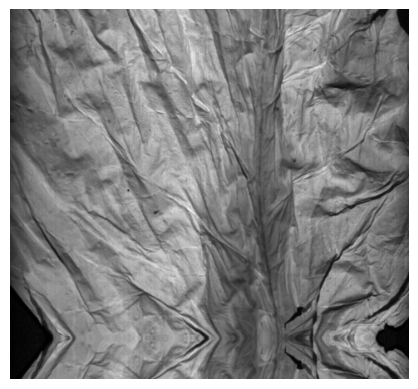

In [5]:
# files = glob.glob(rf'I:\experiment_data\大烟叶\*\*\*.hdr')
# save_folder_path = r'I:\experiment_data\大烟叶\labels'

# for file in files  :
#   msi = spectral.open_image(file).load()
#   file_name = os.path.dirname(file)
#   file_name = os.path.basename(file_name)
#   bianhao  =  os.path.basename(file)
#   combined_path = os.path.join(save_folder_path, os.path.basename(os.path.dirname(os.path.dirname(file))) + file_name + bianhao[:-4] )

#   plt.imshow(msi[:,:,210], cmap='gray')
#   plt.axis('off')
#   plt.savefig(combined_path , dpi=msi.shape[0] , bbox_inches='tight' , pad_inches=0)


### 测试用例

In [2]:
from LineSweep import get_spectral_split , read_hsi , read_roi , get_reflect_line_sweep

d:\Anaconda\envs\spe\Lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


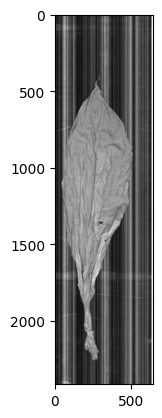

In [3]:
files = glob.glob(rf'H:\大烟叶数据\*\*\*_ref.hdr')
msi = read_hsi(files[0])
plt.imshow(msi[:,:,155], cmap='gray')

In [6]:
files_mask = glob.glob(r'H:\大烟叶数据\mask\*.txt')
files_roi = [file for file in files_mask if 'classes.txt' not in file ] 
rois = read_roi(files_roi[0]) #输入标注文件地址，读取ROI,为【labels , x , y  ,w  h 】 的格式，xy为左上角坐标，wh为宽和高，都是小数形式
print(rois)


[['0', 0.23906199999999997, 0.2910975, 0.429688, 0.257971]]


(np.float64(-0.5), np.float64(639.5), np.float64(2414.5), np.float64(-0.5))

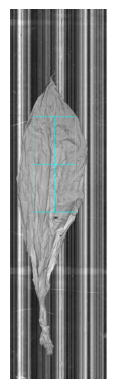

In [7]:
spectrum , labels = get_spectral_split( rois , msi ,True , rows =2 , columns= 2 )
plt.axis('off')

### 批量运行


In [11]:
import glob
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bar
import matplotlib.pyplot as plt

# import importlib
# importlib.reload(LineSweep)
from LineSweep import get_spectral_split , read_hsi , read_roi , get_reflect_line_sweep

# File paths
files =  glob.glob(rf'H:\大烟叶数据\*\*\*_ref.hdr')
files_mask = glob.glob(r'H:\大烟叶数据\mask\*.txt')

files_roi = [file for file in files_mask if 'classes.txt' not in file]
rows=2
columns=2

spectrum_data = []
labels = []

# Use tqdm to create a progress bar for the loop
for i in tqdm(range(len(files_roi)), desc="Processing Files"):
# for i in tqdm(range(2), desc="Processing Files"):
    rois = read_roi(files_roi[i])  # 输出对应图像的ROI， 格式是【【labels，x , y , w  ,h】】
    
    # msi = read_hsi(files[i])  # 输出对应的高光谱图像

    #索引到ROI文件对应的图像，名字能一一对应
    msi_name = [flie for flie in files if os.path.basename(files_roi[i]).split('.')[0] in flie][0]
    msi = read_hsi(msi_name)

    spectrum, label = get_spectral_split(rois, msi, rows=rows, columns=columns)  # 输出光谱图像， roi ， 目标roi的labels 输出希望的光谱, 使用阈值分割的方法

    spectrum_data.append(np.array(spectrum))

    labels.append(np.array(label).reshape(-1))

labels = np.concatenate(labels)
spectrum_data = np.concatenate(spectrum_data)
spectrum_data = spectrum_data.reshape(-1,spectrum_data.shape[2])

Processing Files:   0%|          | 0/50 [00:00<?, ?it/s]d:\Anaconda\envs\spe\Lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
Processing Files: 100%|██████████| 50/50 [1:07:38<00:00, 81.16s/it]


### 查看数据
把数据的labels换成原本的标注的名字

In [14]:
# 读取labels命名文件
files_name = [file for file in files_mask if 'classes.txt' in file ] 
# 打开文本文件
with open(files_name[0], 'r' , encoding='gbk') as file:
    # 读取文件的所有行
    lines = file.readlines()
# 去除每行末尾的换行符
lines = [line.strip() for line in lines]

labels_name = labels
# 替换名字
for i in range(len(lines)) :
  labels_name = np.where(labels_name == str(i), lines[i], labels_name)


# 生成csv文档保存数据
spectrum_data_pd = pd.DataFrame(spectrum_data)
spectrum_data_pd.index = labels_name

# 使用 spectral 库读取元数据
img = spectral.open_image(files[0])
# 提取波长信息
wavelengths = img.metadata['wavelength']

wavelengths = [float(i) for i in wavelengths]
spectrum_data_pd.columns = wavelengths
spectrum_data_pd.to_csv('大烟叶原始反射光谱数据_split.csv')
spectrum_data_pd


d:\Anaconda\envs\spe\Lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


,886.96,888.50,890.05,891.60,893.14,894.70,896.25,897.80,899.36,900.92,...,1710.01,1711.67,1713.34,1715.00,1716.66,1718.32,1719.98,1721.64,1723.30,1724.96
C2F,0.999343,0.999069,0.999505,0.999086,0.998662,0.997012,0.997279,0.992020,0.992815,0.993600,...,0.999890,0.999846,0.999982,0.999945,0.999998,0.999999,1.000000,0.999999,1.000000,1.0
C2F,0.997696,0.996699,0.998047,0.996185,0.995582,0.991257,0.992009,0.980007,0.982064,0.982937,...,0.999875,0.999904,0.999952,0.999974,0.999993,0.999999,0.999996,0.999999,1.000000,1.0
C2F,0.999806,0.999670,0.999866,0.999564,0.999470,0.998678,0.998696,0.996878,0.996618,0.997386,...,0.999949,0.999934,0.999994,0.999985,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
C2F,0.998926,0.998258,0.999101,0.997440,0.997541,0.994931,0.994963,0.988850,0.988191,0.990270,...,0.999933,0.999966,0.999993,0.999992,0.999999,0.999999,0.999997,1.000000,1.000000,1.0
C2F,0.995726,0.993806,0.996875,0.992168,0.991456,0.982940,0.986652,0.971840,0.972761,0.974102,...,0.999243,0.999674,0.999578,0.999871,0.999911,0.999986,0.999991,0.999992,0.999998,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X2F,0.999652,0.999539,0.999763,0.999391,0.999301,0.998543,0.998600,0.995234,0.995461,0.996025,...,0.999998,0.999999,1.000000,0.999999,0.999998,1.000000,1.000000,1.000000,1.000000,1.0
X2F,0.998903,0.998550,0.999029,0.997315,0.997549,0.994679,0.995654,0.985938,0.988192,0.988260,...,0.999947,0.999900,0.999984,0.999994,0.999999,1.000000,0.999998,0.999997,1.000000,1.0
X2F,0.998102,0.997543,0.998518,0.996311,0.996495,0.991614,0.992545,0.981278,0.984028,0.984105,...,0.999979,0.999986,0.999997,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
X2F,0.999273,0.998900,0.999464,0.998320,0.998094,0.995658,0.997035,0.990318,0.990031,0.990854,...,0.999918,0.999958,0.999989,0.999996,0.999999,1.000000,1.000000,0.999999,1.000000,1.0


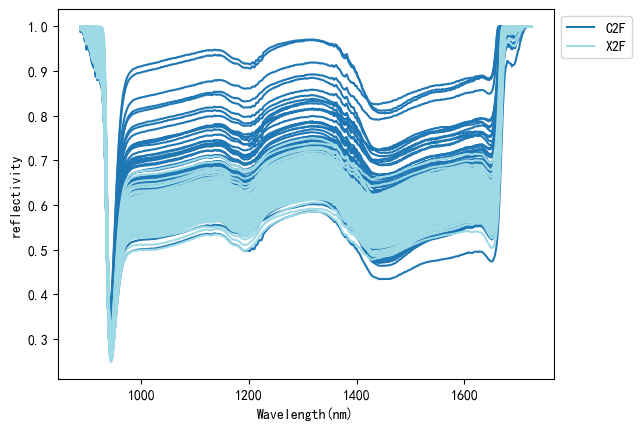

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from SpectrumAnalyse import plot_duplicate_data
from SpectrumAnalyse import split_data

category, split_datas = split_data(labels_name, spectrum_data)
plot_duplicate_data(category, split_datas, wavelengths, type='all')